# SPAM classifier model
The aim of this exercise is to train model which will *classify emails to SPAM and HAM*.
We will use sample emails available here: `https://spamassassin.apache.org/old/publiccorpus/`.
Emails there as classified to spam and ham and compressed to `tar.bz` format. 
## The project is splitted into the following steps:
1) download emails
2) unpack emails to subfolders
3) as the email has different extension convert them to `.txt` files and change their name appoprietly
4) split set of emails into `training` and `test` set
5) rename files in both folders
6) check emails structure and design a transformation that convert an email into a vector of keywords
7) before we use `scikit-learn` models, we design our own model
8) reading all training emails create `spam` and `ham` vectors with unique keywords (then convert them to `dict` and save to a `.json` file)
9) design an abstrac class (in case you wanted to design more models enforcing the same methods in them)
10) create own (fast!) model: idea is simple: read list of words for a test email, convert to set and determine how many words are shared with `spam` set and `ham` set (normalized by sum of total length for both: `spam` and `ham`). Whichever set cardinality is higher, an email get its label (so if an email shares 20 words with SPAM and 15 with HAM, an email is classified as SPAM and get label 1). Based on the file name we retrive an information whether an email is well classified.
11) In the model we use the following notation:
    - `TP` - True Positve, if email was SPAM and its file label is the same
    - `TN` - True Negative, if email was HAM and its file label is the same
    - `FP` - False Positive, if email was classified as SPAM, but its file label was HAM
    - `FN` - False Negative, if email was classified as HAM, but its file label was actually a SPAM
12) we use *Mean Square Error* to measure how this model is good in a comparison to other `scikit-learn` models
13) to use inbuild models one has to join labels from HAM and SPAM in a vector of unique columns and then matrix `X`, where columns are these words and rows are email must be created (for each email 0-1 vector is appened to `X`, 0 if word does not occur, 1 otherwise). Vector `Y` of zeros and ones is additionally created based on file name:  1 if email is spam, 0 otherwise.
14) Models are imported and based on collected data we train them.
15) Test set must also be created: a 0-1 matrix where rows are test emails and columns are words from the matrix `X`. Based on file names we can create validation vector of zeros and ones (0 if email is HAM, 1 otherwise).
16) Based on training data models predict their values.
17) Use MSE to check model validity.

First we load neccesary libraries:

In [85]:
from sklearn.model_selection import train_test_split # splits set of data to training and test sets
from sklearn.linear_model import SGDClassifier, LogisticRegression # loads Stochastic Gradient Descent and logistic regression models
from sklearn.naive_bayes import MultinomialNB # loads naive Bayesian model
from sklearn.tree import DecisionTreeClassifier # loads DecisionTree Classifier
from sklearn.ensemble import RandomForestClassifier # loads Random Forest Classifier
from sklearn.svm import SVC # loads support vector classifier
from sklearn.metrics import f1_score, confusion_matrix, recall_score, precision_score # loads measures of accuracy
from sklearn.model_selection import cross_val_score

from os import rename, mkdir # changes file name/location, creates a folder
from glob import glob # allows to search for a paths that satisfiled a pattern in a given folder
from loguru import logger # allows for loggings 
from tarfile import open as tar_read # allows to unpack tar files
from bs4 import BeautifulSoup # to convert <html> emails to plain text
from json import dump, load as jload #read and write dict to a .json file
from typing import Optional
from abc import ABC, abstractmethod # allows to create an abstract class
from numpy import nan, array, arange
import matplotlib.pyplot as plt

import pandas as pd
import re
import warnings
warnings.filterwarnings("ignore")


Create some global parameters useful across the project

In [2]:
core_path: str = r"C:\Users\Daric\Desktop\antyspam_project" # core path where all project data are kept
subdirs: list[str] = ['easy_ham', 'easy_ham_2', 'hard_ham', 'spam', 'spam_2'] # subfoders where tar.bz were unpacked


Unpack emails from the `tar.bz` compressed files:

In [31]:
tar_file_list: list[str] = glob(core_path + "\\*") # search for files to unpack (at this moment there are only tar.bz files)
for tar_file in tar_file_list:
    with tar_read(tar_file) as tar:
        tar.extractall(path=core_path) # extract all emails from a single pack


Files have ranom extensions
in the folder, therefore in each folder we rename them and standardize their format to `.txt`:

In [32]:
for subdir in subdirs:
    elements: list[str] = glob(core_path + f"\\{subdir}\\*")
    for file in elements:
        rename(file, f"{file.split(".")[0]}_{subdir}.txt") # change extension to .txt


After determining which files must be taken as a `train` set and `test` set, files are refactored to corresponding `train` and `test` sets.

In [33]:
def move_splitted(data_set: list, cur_dir: str, cur_dir: str) -> None:
    """
        Changes location of a file form 'cur_dir' to 'dir_name'.

        :param data_set: list, list of paths to files in 'cur_dir'
        :param cur_dir: str, current directory location of files from 'data_set'
        :param cur_dir: str, target directory
        :returns: None
    """
    
    logger.info(f"{cur_dir}, {dir_name} started")
    for file in data_set:
        path: str = core_path + f"\\{dir_name}"
        rename(file, path + f"\\{file.split("\\")[-1]}") #from a current folder change file location to `dir_name`
    logger.info(f"{cur_dir}, {dir_name} finished")
    

Split emails to `train` and `test` sets:

In [34]:
try: # create `train` and `test` folders
    mkdir(core_path + "\\train")
except:
    pass
try:
    mkdir(core_path + "\\test")
except:
    pass
    
for subdir in subdirs:  #from each `subdir` in `subdirs` we take 20% to test purpose, and remaining to train set
    elements: list[str] = glob(core_path + f"\\{subdir}\\*")
    train_set, test_set = train_test_split(elements, test_size=0.2, random_state=42)
    logger.info(f"Train set and test set determined for {subdir}!")
    move_splitted(train_set, subdir, "train")
    move_splitted(test_set, subdir, "test")


2024-09-28 22:19:48.209 | INFO     | __main__:<module>:13 - Train set and test set determined for easy_ham!
2024-09-28 22:19:48.210 | INFO     | __main__:move_splitted:2 - easy_ham, train started
2024-09-28 22:19:49.382 | INFO     | __main__:move_splitted:6 - easy_ham, train finished
2024-09-28 22:19:49.383 | INFO     | __main__:move_splitted:2 - easy_ham, test started
2024-09-28 22:19:49.696 | INFO     | __main__:move_splitted:6 - easy_ham, test finished
2024-09-28 22:19:49.704 | INFO     | __main__:<module>:13 - Train set and test set determined for easy_ham_2!
2024-09-28 22:19:49.705 | INFO     | __main__:move_splitted:2 - easy_ham_2, train started
2024-09-28 22:19:50.425 | INFO     | __main__:move_splitted:6 - easy_ham_2, train finished
2024-09-28 22:19:50.425 | INFO     | __main__:move_splitted:2 - easy_ham_2, test started
2024-09-28 22:19:50.614 | INFO     | __main__:move_splitted:6 - easy_ham_2, test finished
2024-09-28 22:19:50.616 | INFO     | __main__:<module>:13 - Train set 

Refactor file names in `train` and `test` folders:

In [3]:
for dir_name in ['train', 'test']:
    couter_ham: int = 0
    couter_spam: int = 0
    files: list[str] = glob(core_path + f"\\{dir_name}\\*") # collect all paths
    for file in files:
        if 'ham' in file: # `ham` occurance determines uniquelly a path 
                          # (`spam` name appear in the project directory name, so this reduce complexity)
            rename(file, core_path + f"\\{dir_name}\\ham_{couter_ham}.txt")
            couter_ham += 1
        else:
            rename(file, core_path + f"\\{dir_name}\\spam_{couter_spam}.txt")
            couter_spam += 1 
            

Key part of this project is a function that transforms string email into a list of keywords. Note that important components are:
1) email address of email sender
2) email title
3) email body
All remaining components and metadata can be deleted. Additionally, mails in `<html>` format must be at first cleaned from html symbols.

In [3]:
@logger.catch() # improves catching an error/warning
def split_mail_to_words(emial_path: str, ptr: bool = False) -> list:
    """
        Transforms email from .txt file to list of chracteristic keywords.
    
        :param email_path: str, path to email
        :param ptr: bool, if True email is printed, if False is not
        :returns: list[str], list of keywords characteristic for an email
    """
    
    try:
        mail_body: str = open(emial_path, 'r').read() # read email if possible
    except:
        logger.warning(f"Path {emial_path} has opening issue!")
        return []
    else:
        mail_body = mail_body.lower() # all symbols are transformed to lowercase
        output: list[str] = []
        
        if '<html>' in mail_body: # if email contains html symbols,
                                  # there must be applied additional procedure (See below)
            mail_to_lines: list[str] = mail_body.split("\n") # because email-addresses are usually between <>-bracket,
                                                             # first those must be extracted from the email,
                                                             # so we split text to list by new line symbol
            for line in mail_to_lines:
                if 'subject: ' in line or 'from: ' in line: # looking for lines with 'subject' and 'from:'
                    output += re.split("[ :<>(){}\[\]]", line) # collecting `email address` and `subject`
                                                               # keywords splitted by list of symbol in re.split
            soup = BeautifulSoup(mail_body, 'html.parser') # clean html symbols
            mail_body = soup.get_text() # extract plain text of an email
            
        if ptr: # print email body as per param `ptr`
            print(mail_body)
    
        double_underscore_index: int # index of line in the email that contains
                                     # at least two __ or exactly two --
                                     # (from observation of the struct of emails this
                                     # is comonnly the last line that bring some info)
        mail_to_lines: list[str] = mail_body.split("\n")
        for line in mail_to_lines: # extraction `subject` and `from:` data
            if 'subject: ' in line or 'from: ' in line:
                output += re.split("[ :<>(){}\[\]]", line)
            if re.match("(?:__{2,}|--{2})", line): # getting a lower bound for mail body
                double_underscore_index = mail_to_lines.index(line)
            else:
                double_underscore_index = -1 # if no occurance then full email is considered
        mail_to_lines = mail_to_lines[mail_to_lines.index(""): double_underscore_index] 
                                                                            # metadata ends with new line,
                                                                            # which after splitting is first
                                                                            # occurance of "", so this estimates body of email
        for line in mail_to_lines:
            if not '@' in line and  'http' not in line: # all lines with emails and URL
                                                        # addresses are ommited, we clean line
                                                        # from symbols and split to words
                output += re.split("[ |.\~,\\:$*%?!;&#+=\-(){}\[\]\"\t/]", line)
        output = list(set(output)) # get unique words
        output = list(filter(lambda x: (x.isalpha() == True or '@' in x) and x != '' and x != '/', output)) 
                                                                                                # get only these 
                                                                                                # elements that are emails
                                                                                                # or are pure words, are not
                                                                                                # empty and are not / symbol
        for name in ['from', 'subject']: # if keywords 'from' or 'subject' are
                                         # among output words we can remove them
            try:
                output.remove(name)
            except:
                pass
        output.sort(reverse=False) # sorts words alphabetically
        return output  # returns list of characteristic keywords for an email


Below there are created list of all words characteristic for 'SPAM' and 'HAM' (unique). Due to time consumption of this operation, the dictionary is saved to `.json` file.

In [236]:
all_ham: list[str] = [] # all unique words in ham emails
all_spam: list[str] = [] # # all unique words in spam emails
ham_files: list[str] = glob(core_path + "\\train\\ham_*.txt") # indentify all ham training mail paths
spam_files: list[str] = glob(core_path + "\\train\\spam_*.txt") # indentify all spam training mail paths

for file in ham_files:
    all_ham += split_mail_to_words(file)
    
for file in spam_files:
    all_spam += split_mail_to_words(file)
    
all_ham = list(set(all_ham)) # exclude duplicates
all_spam = list(set(all_spam)) # exclude duplicates
all_ham.sort(reverse=False) # sorting alphabetically ham keywords
all_spam.sort(reverse=False) # sorting alphabetically spam keywords
data_to_json: dict[str: list[str]] = {'ham': all_ham, 'spam': all_spam} # join ham and spam to dictionary

with open(core_path + "\\spam_ham_data.json", 'w+') as json_data:
    dump(data_to_json, json_data, indent=4) # save spam and ham data to `.json`


2024-09-29 17:55:01.584 | WARNING  | __main__:split_mail_to_words:6 - Path C:\Users\Daric\Desktop\antyspam_project\train\ham_571.txt has opening issue!
2024-09-29 17:55:03.336 | WARNING  | __main__:split_mail_to_words:6 - Path C:\Users\Daric\Desktop\antyspam_project\train\spam_177.txt has opening issue!
2024-09-29 17:55:04.133 | WARNING  | __main__:split_mail_to_words:6 - Path C:\Users\Daric\Desktop\antyspam_project\train\spam_520.txt has opening issue!
2024-09-29 17:55:04.145 | WARNING  | __main__:split_mail_to_words:6 - Path C:\Users\Daric\Desktop\antyspam_project\train\spam_525.txt has opening issue!
2024-09-29 17:55:04.791 | WARNING  | __main__:split_mail_to_words:6 - Path C:\Users\Daric\Desktop\antyspam_project\train\spam_798.txt has opening issue!


In case of future implementation of model (and creation a library with models), it is good to have a skeleton that enforce implementation certain methods and their names.

In [4]:
class MLModels(ABC): # abstract class for Machine Learning Models
    
    def __init__(*args, **kwargs):
        pass
        
    @abstractmethod
    def predict(*args, **kwargs):
        pass
        
    @abstractmethod
    def train_model(*args, **kwargs):
        pass
        
    @abstractmethod
    def classification(*args, **kwargs):
        pass
        
    @abstractmethod
    def show_statistcs(*args, **kwargs):
        pass


Below implementation on my own model. It's pros is fast working and low memory consumption:

In [86]:
class SPAMModel(MLModels):
    KERNEL_PATH: str # path to previously saved spam and ham data in .json file
    SPAM: set # set of keywords in SPAM
    HAM: set # set of keywords in HAM
    SPAM_TOTAL: int # number of total number of SPAM keywords
    HAM_TOTAL: int # number of total number of HAM keywords
    TRUE_POSITIVE: int
    TRUE_NEGATIVE: int 
    FALSE_POSITIVE: int
    FALSE_NEGATIVE: int
    
    def __init__(self, path_to_unique_keys: str):
        """
            Instantialization of SPAMModel object.
        
        """
        
        self.KERNEL_PATH = path_to_unique_keys
        with open(path_to_unique_keys, 'r') as json_file:
            dt: dict[str: list[str]] = jload(json_file) # read SPAM and HAM data
        self.SPAM = set(dt['spam']) # convert list to set
        self.HAM = set(dt['ham']) # convert list to set
        self.SPAM_TOTAL = len(dt['spam'])
        self.HAM_TOTAL = len(dt['ham'])
        self.TRUE_POSITIVE = 0
        self.TRUE_NEGATIVE = 0
        self.FALSE_POSITIVE = 0
        self.FALSE_NEGATIVE = 0
    
    def predict(self, emails: list, print_scores: bool = False, classify: bool = True) -> list:
        """
            Based on SPAM and HAM data saved to .json, prediction is made for an email saved to path_to_email.
        
            :param emails: list[str], list of paths to emails in train set
            :param print_scores: bool, if True shows normalized shared keywords values with SPAM and HAM
            :param classify: bool, if True, predictions contribute to statistics
            :returns: list[bool], decision if privided emails are spam (True) or ham (False)
        """

        res: list[bool] = []
        for path_to_email in emails:
            temp: set = set(split_mail_to_words(path_to_email))
            SPAM_SQEW: int = len(list(temp.intersection(self.SPAM)))
            HAM_SQEW: int = len(list(temp.intersection(self.HAM)))
            NORMALIZED_SPAM_SCORE: float = SPAM_SQEW / (self.SPAM_TOTAL + self.HAM_TOTAL)
            NORMALIZED_HAM_SCORE: float = HAM_SQEW / (self.SPAM_TOTAL + self.HAM_TOTAL)
            if classify:
                self.classification(path_to_email, NORMALIZED_SPAM_SCORE, NORMALIZED_HAM_SCORE)
            if print_scores:
                print(dict({'SPAM_SQEW': NORMALIZED_SPAM_SCORE, 'HAM_SQEW': NORMALIZED_HAM_SCORE}))
            res.append(True if NORMALIZED_SPAM_SCORE >= NORMALIZED_HAM_SCORE else False)
            
        return res
    
    def train_model(self, path_to_train_dir: str, dump_kernel_file_name: Optional[str] = None) -> None:
        """
            Unique keywords in the folder 'path_to_train_dir' are added to SPAM, HAM, and saved to .json.
        
            :param path_to_train_dir: str, path to a directory where additional training data are saved
            :param dump_kernel_file_name: Optional[str], if None, original .json with dict with 'spam' and 'ham' is replaced, 
                                                         if not None, dict is dumped to a privided path
            :returns: None
        """
        
        spam_files: list[str] = glob(path_to_train_dir + "\\spam_*.txt") # select paths to spam mails
        ham_files: list[str] = glob(path_to_train_dir + "\\ham_*.txt") # select paths to ham mails
        for file in spam_files:
            self.SPAM += split_mail_to_words(file) # add new keywords to SPAM
        for file in ham_files:
            self.HAM += split_mail_to_words(file) # add new keywords to HAM
        self.SPAM = list(set(self.SPAM)) # get unique keywords
        self.HAM = list(set(self.HAM))
        self.SPAM.sort(reverse=False) # sort alphabetically all keywords
        self.HAM.sort(reverse=False)
        dt: dict[str: list[str]] = {'spam': self.SPAM, 'ham': self.HAM} # consolidated 'spam' and 'ham' to a dictionary
        path: str = dump_kernel_file_name if dump_kernel_file_name else self.KERNEL_PATH # determine path to save dt
        dump(dt, path) # save dt to .json file
        logger.info(f"Spam kernel updated from {path_to_train_dir} data. Kernel saved to {path}.")

    def classification(self, path_to_email: str, spam_score: float, ham_score: float) -> None:
        """
            Based on 'spam_score', 'ham_score' and 'path_to_email' it is determined if prediction made was correct.
            Statistical data on this classification is updated.
         
            :param path_to_email: str, path to an email, its name is utilized to verification if email was truly spam or ham
            :param spam_score: float, how many keywords in test email is shared with spam normalized by sum of lengths of spam and ham
            :param ham_score: float, how many keywords in test email is shared with ham normalized by sum of lengths of spam and ham
            :returns: None
        """
        
        name: str = 'ham' if 'ham' in path_to_email else 'spam' # determine if originally the email is spam or ham
        prediction: str = 'spam' if spam_score >= ham_score else 'ham' # model prediction
        if prediction == name == 'spam': # result classification
            self.TRUE_POSITIVE += 1
        elif  prediction == name == 'ham':
            self.TRUE_NEGATIVE += 1
        elif prediction == 'spam' and name == 'ham':
            self.FALSE_POSITIVE += 1
        else:
            self.FALSE_NEGATIVE += 1
            
    def show_statistcs(self) -> None:
        """
        Prints statistcs like: TP, TN, FP, FN, their % contribution to size of the sample, classification statistics and Precision + Completeness.

        :returns: None
        """
        
        precision: float = self.TRUE_POSITIVE / (self.TRUE_POSITIVE + self.FALSE_POSITIVE)
        recall: float = self.TRUE_POSITIVE / (self.TRUE_POSITIVE + self.FALSE_NEGATIVE)
        TOTAL: int = self.TRUE_POSITIVE + self.TRUE_NEGATIVE + self.FALSE_POSITIVE + self.FALSE_NEGATIVE
        print({'TP': self.TRUE_POSITIVE, 
               'TN': self.TRUE_NEGATIVE, 
               'FP': self.FALSE_POSITIVE, 
               'FN': self.FALSE_NEGATIVE})
        print({'TP%': self.TRUE_POSITIVE / TOTAL * 100, 
               'TN%': self.TRUE_NEGATIVE / TOTAL * 100,
               'FP%': self.FALSE_POSITIVE / TOTAL * 100,
               'FN%': self.FALSE_NEGATIVE / TOTAL * 100})
        print({"Precision": precision, 
               "Recall": recall})
        print('F1:', 2 / (1 / recall + 1 / precision))
        
    def confusion_matrix(self) -> array:
        return array([[self.TRUE_NEGATIVE, self.FALSE_POSITIVE], [self.FALSE_NEGATIVE, self.TRUE_POSITIVE]])

    
    def __del__(self):
        """
            Destructor. Clean statistic data for MLSpam object.
            
        """
        
        self.SPAM_TOTAL = 0
        self.HAM_TOTAL = 0
        self.TRUE_POSITIVE = 0
        self.TRUE_NEGATIVE = 0
        self.FALSE_POSITIVE = 0
        self.FALSE_NEGATIVE = 0
        

Below predition of above model on test data.

In [87]:
spam_model: SPAMModel = SPAMModel(r"C:\Users\Daric\Desktop\antyspam_project\spam_ham_data.json")
paths: list[str] = glob(core_path + "\\test\\*.txt")
spam_model.predict(paths)
spam_model.show_statistcs()
print(spam_model.confusion_matrix())
del spam_model



2024-10-06 11:15:50.783 | WARNING  | __main__:split_mail_to_words:14 - Path C:\Users\Daric\Desktop\antyspam_project\test\spam_120.txt has opening issue!
2024-10-06 11:15:51.334 | WARNING  | __main__:split_mail_to_words:14 - Path C:\Users\Daric\Desktop\antyspam_project\test\spam_345.txt has opening issue!
2024-10-06 11:15:51.572 | WARNING  | __main__:split_mail_to_words:14 - Path C:\Users\Daric\Desktop\antyspam_project\test\spam_97.txt has opening issue!


{'TP': 330, 'TN': 830, 'FP': 3, 'FN': 51}
{'TP%': 27.182866556836906, 'TN%': 68.36902800658979, 'FP%': 0.2471169686985173, 'FN%': 4.200988467874795}
{'Precision': 0.990990990990991, 'Recall': 0.8661417322834646}
F1: 0.9243697478991597
[[830   3]
 [ 51 330]]


We do the same on `train` data to see how good the model is.

In [88]:
spam_model1: SPAMModel = SPAMModel(r"C:\Users\Daric\Desktop\antyspam_project\spam_ham_data.json")
paths: list[str] = glob(core_path + "\\train\\*.txt")
spam_model1.predict(paths)
spam_model1.show_statistcs()
print(spam_model1.confusion_matrix())
del spam_model1


2024-10-06 11:16:04.630 | WARNING  | __main__:split_mail_to_words:14 - Path C:\Users\Daric\Desktop\antyspam_project\train\ham_571.txt has opening issue!
2024-10-06 11:16:06.474 | WARNING  | __main__:split_mail_to_words:14 - Path C:\Users\Daric\Desktop\antyspam_project\train\spam_177.txt has opening issue!
2024-10-06 11:16:07.296 | WARNING  | __main__:split_mail_to_words:14 - Path C:\Users\Daric\Desktop\antyspam_project\train\spam_520.txt has opening issue!
2024-10-06 11:16:07.318 | WARNING  | __main__:split_mail_to_words:14 - Path C:\Users\Daric\Desktop\antyspam_project\train\spam_525.txt has opening issue!
2024-10-06 11:16:07.943 | WARNING  | __main__:split_mail_to_words:14 - Path C:\Users\Daric\Desktop\antyspam_project\train\spam_798.txt has opening issue!


{'TP': 1518, 'TN': 3317, 'FP': 3, 'FN': 0}
{'TP%': 31.37660190161224, 'TN%': 68.56138900372054, 'FP%': 0.06200909466721786, 'FN%': 0.0}
{'Precision': 0.9980276134122288, 'Recall': 1.0}
F1: 0.9990128331688054
[[3317    3]
 [   0 1518]]


Now we aim to use `scikit-learn` selected models to train AntiSpam model. For this purpose we need two objects: matrix which rows corresponds to 0-1 vectors, columns are unique keywords (all SPAM and HAM), and 1 corresponds to word occurance and 0 to its lack of presence, and a vector which assign 1 to a sample that is SPAM, 0 if HAM (actual, not predicted, data). We use for this purpose `pandas.DataFrame`. Process of creation both objects is extremally time consuming.

In [26]:
with open(r"C:\Users\Daric\Desktop\antyspam_project\spam_ham_data.json", 'r') as json_file:
    dt: dict[str: list[str]] = jload(json_file) #read SPAM and HAM uniqhe keywords
    
X: pd.DataFrame = pd.DataFrame(index=list(set(dt['spam'] + dt['ham']))) # create DataFrame with index equal to unique keywords in train data
y: list[int] = []

paths: list[str] = glob(core_path + "\\train\\*.txt")
iterator: int = 0
temp: pd.DataFrame

for path in paths:
    temp = pd.DataFrame(index=split_mail_to_words(path))
    temp[f'X{iterator}'] = 1 # to all unique keywords in temp assign 1 to show presence of this keyword
    X = X.merge(temp, left_index=True, right_index=True, how='left') # append temp as a new row to X
    iterator += 1
    if 'spam' in path.split("\\")[-1]: # create label that verify if an email is SPAM or HAM to Y
        y.append(1)
    else:
        y.append(0)
        

Y: pd.DataFrame = pd.DataFrame({'type': y}) # create pandas.DataFrame with True values of SPAM/HAM of train data
X = X.fillna(0).astype(int) # fill missing values with zeros and treat them as integer values
X.to_csv(core_path + f"\\X.csv") #save DataFrame in case of futrther need (to avoid time consumption)
Y.to_csv(core_path + f"\\Y.csv", index=False)


2024-10-02 10:15:32.194 | WARNING  | __main__:split_mail_to_words:6 - Path C:\Users\Daric\Desktop\antyspam_project\train\ham_571.txt has opening issue!
2024-10-02 10:32:25.131 | WARNING  | __main__:split_mail_to_words:6 - Path C:\Users\Daric\Desktop\antyspam_project\train\spam_177.txt has opening issue!
2024-10-02 10:39:48.483 | WARNING  | __main__:split_mail_to_words:6 - Path C:\Users\Daric\Desktop\antyspam_project\train\spam_520.txt has opening issue!
2024-10-02 10:39:54.544 | WARNING  | __main__:split_mail_to_words:6 - Path C:\Users\Daric\Desktop\antyspam_project\train\spam_525.txt has opening issue!
2024-10-02 10:45:59.188 | WARNING  | __main__:split_mail_to_words:6 - Path C:\Users\Daric\Desktop\antyspam_project\train\spam_798.txt has opening issue!


Below, as I wanted to continue work on the project another day, I had to read X and Y matrices. It turned out that word 'null' is converted to `numpy.nan`. Hence enforicing the column name 'null' was required. 

In [6]:
X: pd.DataFrame  = pd.read_csv(core_path + "\\X.csv", index_col=0)
Y: pd.DataFrame  = pd.read_csv(core_path + "\\Y.csv")
X = X.rename({nan: 'null'})


Train selected models on created X and Y data. Selected models are:
- Stochastic Gradient Classifier
- Logistic Regression
- Naive Bayessian Model
- Support Vector Machine (extermally time consuming)
- Decision Tree Classifier
- Random Forest Classifier

In [49]:
lm: SGDClassifier = SGDClassifier()
lm.fit(X.T, Y)

SGDClassifier()

In [50]:
logm: LogisticRegression = LogisticRegression()
logm.fit(X.T, Y)

LogisticRegression()

In [53]:
nbayesm: MultinomialNB = MultinomialNB()
nbayesm.fit(X.T, Y)

MultinomialNB()

In [52]:
svcm: SVC = SVC()
svcm.fit(X.T, Y)

SVC()

In [54]:
dectreem: DecisionTreeClassifier = DecisionTreeClassifier()
dectreem.fit(X.T, Y)

DecisionTreeClassifier()

In [55]:
rforestm: RandomForestClassifier = RandomForestClassifier()
rforestm.fit(X.T, Y)

RandomForestClassifier()

Time to prepare test data as well. For this we consolidate them in X-like `pandas.DataFrame`.

In [28]:
paths: list[str] = glob(core_path + "\\test\\*.txt")
df: pd.DataFrame
test: list[str]
df_test: pd.DataFrame = pd.DataFrame(columns = X.index)
labels: list[int] = [0] * len(paths)
iterator: int = 0
X_len: int = len(X.index.to_list())

dfs: list[pd.DataFrame] = []
for path in paths:
    df = pd.DataFrame([[0] * X_len], columns=X.index) # creates a single-row pandas.DataFrame
                                                      # filled with 0s and with columns equal
                                                      # to X.index i.e. unique keywords
    test = split_mail_to_words(path)
    
    for word in test:
        if word in df.columns: # fill with 1s these columns that
                               # indicates presence of a word in test email
            df.at[0, word] = 1

    dfs.append(df) # append 1-row pandas.DataFrame to dfs 
                   # (optimization: single, large pd.DataFrame could not be time-efficient)

    if 'spam' in path.split("\\")[-1]: # determine the validation data based on path to an email
        labels[iterator] = 1
        
    df = None
    iterator += 1

df_test = pd.concat(dfs, ignore_index=True) # consolidation of all 1-row DataFrames
                                            # to a single large X-like pandas.DataFrame
df_labels: pd.DataFrame = pd.DataFrame({'type': labels}) # convert the list of 0-1 to pd.DataFrame
df_test.to_csv(core_path + "\\test_set.csv")
df_labels.to_csv(core_path + "\\label_set.csv")

2024-10-04 16:44:07.794 | WARNING  | __main__:split_mail_to_words:13 - Path C:\Users\Daric\Desktop\antyspam_project\test\spam_120.txt has opening issue!
2024-10-04 16:45:55.665 | WARNING  | __main__:split_mail_to_words:13 - Path C:\Users\Daric\Desktop\antyspam_project\test\spam_345.txt has opening issue!
2024-10-04 16:46:40.185 | WARNING  | __main__:split_mail_to_words:13 - Path C:\Users\Daric\Desktop\antyspam_project\test\spam_97.txt has opening issue!


Let's read test data and their original values:

In [77]:
df_test: pd.DataFrame = pd.read_csv(core_path + "\\test_set.csv", index_col=0)
df_labels: array = array(pd.read_csv(core_path + "\\label_set.csv")['type'])


Below predictions run, Cross Validation Scores, Confussion Matrices and F1 scores on Trained data for pre-selected models:

In [79]:
lm_predictions = lm.predict(df_test)
lm_cvs = cross_val_score(lm, X.T, Y, cv=3, scoring='accuracy')
print(lm_cvs)
print(confusion_matrix(lm_predictions, df_labels))
print(f1_score(lm_predictions, df_labels))
print({'Precision': precision_score(lm_predictions, df_labels), 'Recall': recall_score(lm_predictions, df_labels)})

[0.96714197 0.95846249 0.96526055]
[[816   7]
 [ 17 374]]
0.9689119170984456
{'Precision': 0.9816272965879265, 'Recall': 0.9565217391304348}


In [80]:
logm_predictions = logm.predict(df_test)
logm_cvs = cross_val_score(logm, X.T, Y, cv=3, scoring='accuracy')
print(logm_cvs)
print(confusion_matrix(logm_predictions, df_labels))
print(f1_score(logm_predictions, df_labels))
print({'Precision': precision_score(logm_predictions, df_labels), 'Recall': recall_score(logm_predictions, df_labels)})

[0.97644141 0.96962182 0.95843672]
[[822  13]
 [ 11 368]]
0.968421052631579
{'Precision': 0.9658792650918635, 'Recall': 0.9709762532981531}


In [81]:
nbayesm_predictions = nbayesm.predict(df_test)
nbayesm_cvs = cross_val_score(nbayesm, X.T, Y, cv=3, scoring='accuracy')
print(nbayesm_cvs)
print(confusion_matrix(nbayesm_predictions, df_labels))
print(f1_score(nbayesm_predictions, df_labels))
print({'Precision': precision_score(nbayesm_predictions, df_labels), 'Recall': recall_score(nbayesm_predictions, df_labels)})

[0.96280223 0.97210167 0.97084367]
[[824  17]
 [  9 364]]
0.9655172413793104
{'Precision': 0.9553805774278216, 'Recall': 0.9758713136729222}


In [84]:
svcm_predictions = svcm.predict(df_test)
svcm_cvs = cross_val_score(svcm, X.T, Y, cv=3, scoring='accuracy')
print(svcm_cvs)
print(confusion_matrix(svcm_predictions, df_labels))
print(f1_score(svcm_predictions, df_labels))
print({'Precision': precision_score(svcm_predictions, df_labels), 'Recall': recall_score(svcm_predictions, df_labels)})

[0.96652201 0.94916305 0.95471464]
[[821  22]
 [ 12 359]]
0.9547872340425532
{'Precision': 0.9422572178477691, 'Recall': 0.967654986522911}


In [82]:
dectreem_predictions = dectreem.predict(df_test)
dectreem_cvs = cross_val_score(dectreem, X.T, Y, cv=3, scoring='accuracy')
print(dectreem_cvs)
print(confusion_matrix(dectreem_predictions, df_labels))
print(f1_score(dectreem_predictions, df_labels))
print({'Precision': precision_score(dectreem_predictions, df_labels), 'Recall': recall_score(dectreem_predictions, df_labels)})

[0.89770614 0.90142591 0.91873449]
[[782  32]
 [ 51 349]]
0.8937259923175416
{'Precision': 0.916010498687664, 'Recall': 0.8725}


In [83]:
rforestm_predictions = rforestm.predict(df_test)
rforestm_cvs = cross_val_score(rforestm, X.T, Y, cv=3, scoring='accuracy')
print(rforestm_cvs)
print(confusion_matrix(rforestm_predictions, df_labels))
print(f1_score(rforestm_predictions, df_labels))
print({'Precision': precision_score(rforestm_predictions, df_labels), 'Recall': recall_score(rforestm_predictions, df_labels)})

[0.96094234 0.95040298 0.9528536 ]
[[823  25]
 [ 10 356]]
0.9531459170013387
{'Precision': 0.9343832020997376, 'Recall': 0.9726775956284153}


Now, before we do analysis and infer conclusion, we plot `precision`, `recall` and `f1` measures:

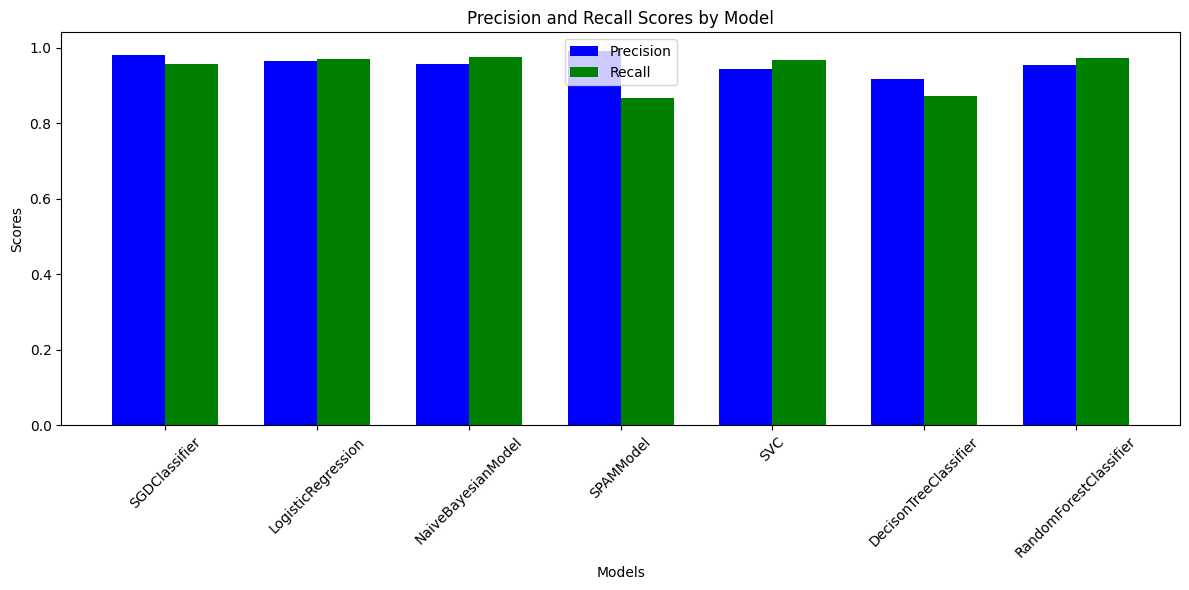

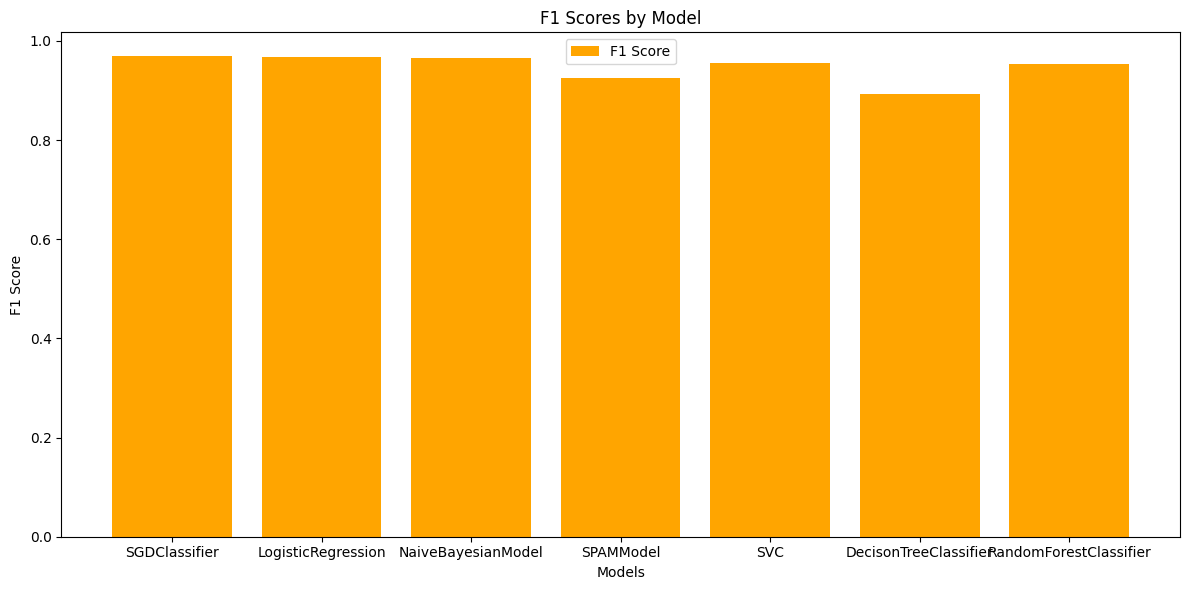

In [90]:
import matplotlib.pyplot as plt
import numpy as np

# Dane
models = ["SGDClassifier", "LogisticRegression", "NaiveBayesianModel", "SPAMModel", 
          "SVC", "DecisonTreeClassifier", "RandomForestClassifier"]

precision = [0.9816272965879265, 0.9658792650918635, 0.9553805774278216, 0.990990990990991, 
             0.9422572178477691, 0.916010498687664, 0.9531459170013387]

recall = [0.9565217391304348, 0.9709762532981531, 0.9758713136729222, 0.8661417322834646, 
          0.967654986522911, 0.8725, 0.9726775956284153]

f1 = [0.9689119170984456, 0.968421052631579, 0.9655172413793104, 0.9243697478991597, 
      0.9547872340425532, 0.8937259923175416, 0.9531459170013387]

# Szerokość słupków i pozycje
bar_width = 0.35
index = np.arange(len(models))

# Tworzenie wykresu Precision i Recall
fig, ax1 = plt.subplots(figsize=(12, 6))

# Rysowanie precision i recall
bars1 = ax1.bar(index, precision, bar_width, label='Precision', color='b')
bars2 = ax1.bar(index + bar_width, recall, bar_width, label='Recall', color='g')

# Dodanie etykiet, tytułu i legendy
ax1.set_xlabel('Models')
ax1.set_ylabel('Scores')
ax1.set_title('Precision and Recall Scores by Model')
ax1.set_xticks(index + bar_width / 2)
ax1.set_xticklabels(models, rotation=45)
ax1.legend()

# Wyświetlanie wykresu
plt.tight_layout()
plt.show()

# Tworzenie wykresu F1
fig, ax2 = plt.subplots(figsize=(12, 6))

# Rysowanie wykresu F1
bars3 = ax2.bar(models, f1, color='orange', label='F1 Score')

# Dodanie etykiet, tytułu i legendy
ax2.set_xlabel('Models')
ax2.set_ylabel('F1 Score')
ax2.set_title('F1 Scores by Model')
ax2.legend()

# Wyświetlanie wykresu
plt.tight_layout()
plt.show()



## Models Analysis
Below ranking of the best choices for models that could serve as anti-spam model ( a) Precision, b) Recall, c) F1 score)):
### a) Precision

1) SPAMModel
2) SGDClassifier
3) LogisticRegression
4) NaiveBayesianModel
5) RandomForestClassifier
6) SVC
7) DecisonTreeClassifier
### b) Recall

1) NaiveBayesianModel
2) RandomForestClassifier
3) LogisticRegression
4) SVC
5) SGDClassifier
6) DecisonTreeClassifier
7) SPAMModel

### c) F1 score
1) SGDClassifier
2) LogisticRegression
3) NaiveBayesianModel
4) SVC
5) RandomForestClassifier
6) SPAMModel
7) DecisonTreeClassifier

## Remarks
All mmodels (except SPAMModel) requirs a specific form of input data (X,Y). Their preparation is time, and memory comsuming. Among them are extremly good models, fast in training and prediction (*SGDClassifier*, *Logistic Regression* or *Naive Bayesian Model*), but also extremally slow: *SVC*. On the other hand *SPAMModel* is less requiring (time, memory, disc space), it gives a bit worse results than the best models, but *F1* is still acceptable.
## Conclusions
Depending on need, the choice of the best model may depend on `Precision`, `Recall`, or `F1 score`, additionaly if memory, time of implementation, collecting data for matrices X and Y (and additionally disc space) does not play a role then the best choices are `SGDClassifier`, `Naive Bayesian Model` or `Logistic Regression`. If however, one of these factor play a role `SPAMModel` also is a decent choice.